<a href="https://colab.research.google.com/github/Raycena12/NLP-Medical-Abstracts-TensorFlow/blob/main/SkimLit_(PubMed_200k).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Making Abstracts more readable with Deep Learning
Building an NLP (Natural Language Processing) Model that can make Medical abstracts easier to read.

In [1]:
# Checking the GPU
!nvidia-smi

Tue Sep  5 22:13:49 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Get Data


In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (33/33), 177.08 MiB | 23.02 MiB/s, done.
Resolving deltas: 100% (12/12), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [3]:
# Check what files are in the PubMed_20k dataset
!ls pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.zip


In [4]:
# Making a data directory
data_dir = "/content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/"

In [5]:
# Unzipping train file in file directory
import zipfile
zget = zipfile.ZipFile("/content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/train.zip")
zget.extractall()
zget.close()

In [ ]:
# Moving text file to proper location
os.rename("/content/train.txt", "/content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/train.txt")

In [7]:
# Check all of the filenames in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/dev.txt']

## Preprocessing Data

In [8]:
# Preprocessing function to open txt files
def read_txt_lines(filename):
  """
  Reads in text files
  """
  with open(filename) as f:
    txt = f.readlines()
  return txt

In [9]:
# Creating a preprocessing function to seperate
def preprocess_txt_with_line_numbers(filename):
  """
  Returns a list of dictionaries of abstract line data.
  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence
  number the target line is
  """
  input_lines = read_txt_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts

  # Loop through each line in the target file
  for line in input_lines:
    if line.startswith("###"): # check to see if starts with and ID line
      abstract_id = line
      abstract_lines = "" # reset the abstract string if the line is an ID line

    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into seperate lines

      # Iterate through each line in a single abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create an empty dictionary for each line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lowercase it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split)-1 # how many total lines are there in the target abstract? (starting from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list

    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line

  return abstract_samples

In [12]:
# get data from file and preprocess it
train_samples = preprocess_txt_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_txt_with_line_numbers(data_dir + "dev.txt")
test_samples = preprocess_txt_with_line_numbers(data_dir + "test.txt")
print(len(train_samples), len(val_samples), len(test_samples))

2211861 28932 29493


In [13]:
# Check the first abstract of our training data
train_samples[:15]

[{'target': 'BACKGROUND',
  'text': 'the emergence of hiv as a chronic condition means that people living with hiv are required to take more responsibility for the self-management of their condition , including making physical , emotional and social adjustments .',
  'line_number': 0,
  'total_lines': 10},
 {'target': 'BACKGROUND',
  'text': 'this paper describes the design and evaluation of positive outlook , an online program aiming to enhance the self-management skills of gay men living with hiv .',
  'line_number': 1,
  'total_lines': 10},
 {'target': 'METHODS',
  'text': 'this study is designed as a randomised controlled trial in which men living with hiv in australia will be assigned to either an intervention group or usual care control group .',
  'line_number': 2,
  'total_lines': 10},
 {'target': 'METHODS',
  'text': "the intervention group will participate in the online group program ` positive outlook ' .",
  'line_number': 3,
  'total_lines': 10},
 {'target': 'METHODS',
  '

In [14]:
# Visualizing the data in pandas
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df

,target,text,line_number,total_lines
0,BACKGROUND,the emergence of hiv as a chronic condition me...,0,10
1,BACKGROUND,this paper describes the design and evaluation...,1,10
2,METHODS,this study is designed as a randomised control...,2,10
3,METHODS,the intervention group will participate in the...,3,10
4,METHODS,the program is based on self-efficacy theory a...,4,10
...,...,...,...,...
2211856,METHODS,"after crossover , the wait-list group received...",5,9
2211857,METHODS,performance was assessed by comparison to amer...,6,9
2211858,RESULTS,performance improved significantly after simul...,7,9
2211859,RESULTS,no improvement was detected as a function of c...,8,9


In [15]:
# Grabbing Sentences from pandas data frame and turning them into a list
train_sentences = train_df['text'].to_list()
val_sentences = val_df['text'].to_list()
test_sentences = test_df['text'].to_list()
train_sentences[:10]

['the emergence of hiv as a chronic condition means that people living with hiv are required to take more responsibility for the self-management of their condition , including making physical , emotional and social adjustments .',
 'this paper describes the design and evaluation of positive outlook , an online program aiming to enhance the self-management skills of gay men living with hiv .',
 'this study is designed as a randomised controlled trial in which men living with hiv in australia will be assigned to either an intervention group or usual care control group .',
 "the intervention group will participate in the online group program ` positive outlook ' .",
 'the program is based on self-efficacy theory and uses a self-management approach to enhance skills , confidence and abilities to manage the psychosocial issues associated with hiv in daily life .',
 'participants will access the program for a minimum of @ minutes per week over seven weeks .',
 'primary outcomes are domain sp

### One Hot Encoding Labels

In [62]:
from sklearn.preprocessing import OneHotEncoder
one_hot_en = OneHotEncoder(sparse=False)
train_labels_OneHot = one_hot_en.fit_transform(train_df['target'].to_numpy().reshape(-1,1))
val_labels_OneHot = one_hot_en.transform(val_df['target'].to_numpy().reshape(-1,1))
test_labels_OneHot = one_hot_en.transform(test_df['target'].to_numpy().reshape(-1,1))

# Check out what one hot encoded labels look like
train_labels_OneHot

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]])

### Label Encoding Labels

In [80]:
from sklearn.preprocessing import LabelEncoder
lab_en = LabelEncoder()
train_labels_LE = lab_en.fit_transform(train_df['target'].to_numpy())
val_labels_LE = lab_en.transform(val_df['target'].to_numpy())
test_labels_LE = lab_en.transform(test_df['target'].to_numpy())

train_labels_LE

array([0, 0, 2, ..., 4, 4, 4])

### Getting class names and numbers

In [18]:
class_num = len(lab_en.classes_)
class_names = lab_en.classes_
class_num, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

<Axes: ylabel='Frequency'>

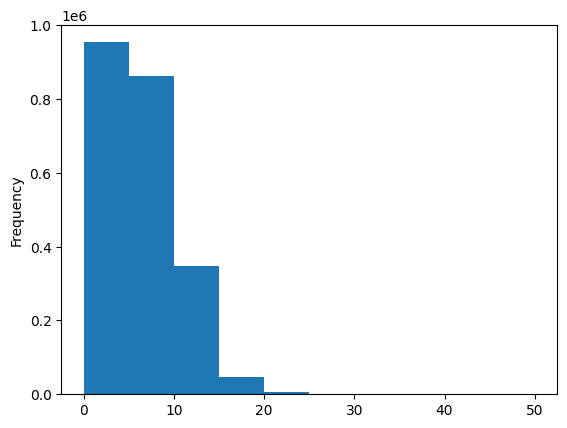

In [20]:
# Check the distribution of 'line_numer' column
train_df.line_number.plot.hist()

In [22]:
# Use TensorFlow to create one-hot-encoded tensors of our 'line_numer' column
train_line_numbers_OneHot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_OneHot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_OneHot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)
train_line_numbers_OneHot[:12], train_line_numbers_OneHot.shape

(<tf.Tensor: shape=(12, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       dtype=float32)>,
 TensorShape([2211861, 15]))

<Axes: ylabel='Frequency'>

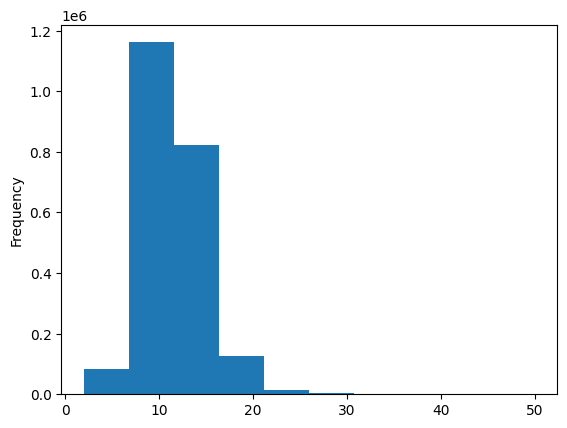

In [23]:
train_df["total_lines"].plot.hist()

In [24]:
# One Hot encoding total lines
train_total_lines_OneHot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_OneHot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_OneHot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)
train_total_lines_OneHot[:10], train_total_lines_OneHot.shape

(<tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0

## Building the Model
This model will have
* Token embeddings (Pre-Trained)
* Character Embeddings
* Positional Embeddings

### Getting the pre-trained token embedding from tensorflow hub

In [25]:
import tensorflow_hub as hub
text_embeddings = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                 input_shape=[], # shape of inputs coming to our model
                                 dtype=tf.string, # data type of inputs coming to the USE layer
                                 trainable=False, # keep the pretrained weights (we'll create a feature extractor)
                                 name="Universal_Sentence_Encoder")

### Creating a Character Vectorizer & Embedding Layer

In [26]:
list(train_sentences[0][:10])

['t', 'h', 'e', ' ', 'e', 'm', 'e', 'r', 'g', 'e']

In [27]:
" ".join(list(train_sentences[0]))

't h e   e m e r g e n c e   o f   h i v   a s   a   c h r o n i c   c o n d i t i o n   m e a n s   t h a t   p e o p l e   l i v i n g   w i t h   h i v   a r e   r e q u i r e d   t o   t a k e   m o r e   r e s p o n s i b i l i t y   f o r   t h e   s e l f - m a n a g e m e n t   o f   t h e i r   c o n d i t i o n   ,   i n c l u d i n g   m a k i n g   p h y s i c a l   ,   e m o t i o n a l   a n d   s o c i a l   a d j u s t m e n t s   .'

In [28]:
import random
# Make function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

# Text Splitting non-character-level sequence into characters
split_chars(random.choice(train_sentences))

'a n e s t h e s i a   w a s   i n d u c e d   w i t h   m e d a z a l a m   @   m g / k g   ,   f e n t a n y l   @   m i c r o g / k g   a n d   v e c u r o n i u m   @   m g / k g   ;   a n d   w e r e   m a i n t a i n e d   w i t h   f e n t a n y l   a n d   p r o p o f o l   i n f u s i o n   .'

In [29]:
# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
train_chars[:5]

['t h e   e m e r g e n c e   o f   h i v   a s   a   c h r o n i c   c o n d i t i o n   m e a n s   t h a t   p e o p l e   l i v i n g   w i t h   h i v   a r e   r e q u i r e d   t o   t a k e   m o r e   r e s p o n s i b i l i t y   f o r   t h e   s e l f - m a n a g e m e n t   o f   t h e i r   c o n d i t i o n   ,   i n c l u d i n g   m a k i n g   p h y s i c a l   ,   e m o t i o n a l   a n d   s o c i a l   a d j u s t m e n t s   .',
 't h i s   p a p e r   d e s c r i b e s   t h e   d e s i g n   a n d   e v a l u a t i o n   o f   p o s i t i v e   o u t l o o k   ,   a n   o n l i n e   p r o g r a m   a i m i n g   t o   e n h a n c e   t h e   s e l f - m a n a g e m e n t   s k i l l s   o f   g a y   m e n   l i v i n g   w i t h   h i v   .',
 't h i s   s t u d y   i s   d e s i g n e d   a s   a   r a n d o m i s e d   c o n t r o l l e d   t r i a l   i n   w h i c h   m e n   l i v i n g   w i t h   h i v   i n   a u s t r a l i a   w i l l   b e   a s s 

In [30]:
# Finding the average character length?
import numpy as np
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

147.82646377869133

(array([2.030236e+06, 1.779350e+05, 3.470000e+03, 1.980000e+02,
        2.000000e+01, 1.000000e+00, 1.000000e+00]),
 array([1.00000000e+00, 2.54428571e+02, 5.07857143e+02, 7.61285714e+02,
        1.01471429e+03, 1.26814286e+03, 1.52157143e+03, 1.77500000e+03]),
 <BarContainer object of 7 artists>)

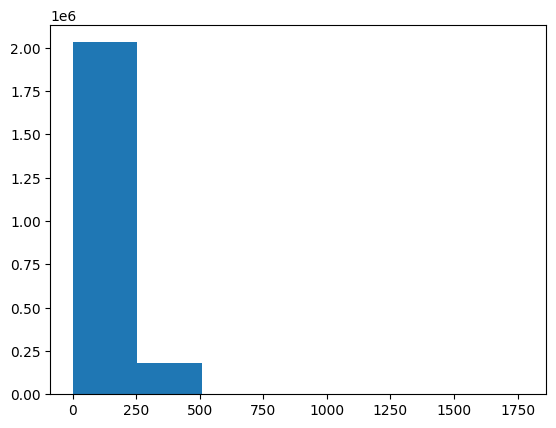

In [31]:
# check the distribution of our sequences at a character-level
import matplotlib.pyplot as plt
plt.hist(char_lens,bins=7)

In [32]:
# Find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens,95))
output_seq_char_len

284

In [33]:
# Get all keyboard characters
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [34]:
from keras.layers import TextVectorization
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS =  len(alphabet) + 2 # add 2 for space and OOV token (OOV = out of vocab, '[UNK]')
char_vectorizer = TextVectorization(max_tokens = NUM_CHAR_TOKENS,
                                    output_sequence_length = output_seq_char_len,
                                    name = "char_vectorizer")

In [39]:
# Adapt vectorizer to first 20,000 training characters
char_vectorizer.adapt(train_chars[:20000])

In [41]:
from tensorflow.keras import layers
char_vocab = char_vectorizer.get_vocabulary()
char_embed = layers.Embedding(input_dim = len(char_vocab), # number of different characters
                              output_dim = 25, # this is the size of the char embedding in the paper: https://arxiv.org/pdf/1612.05251.pdf (Figure 1)
                              input_length = output_seq_char_len,
                              name = 'char_embed')
char_embed

### The Model

In [42]:
import tensorflow as tf

In [47]:
# Input Layers
token_inputs = tf.keras.Input(shape=[], dtype=tf.string)
char_inputs = tf.keras.Input(shape=(1,), dtype=tf.string)
line_numer_input = tf.keras.Input(shape=(15,), dtype=tf.float32)
total_line_input = tf.keras.Input(shape=(20,), dtype=tf.float32)


# Creating a token embedding section
pretrained_embedding = text_embeddings(token_inputs)
x1 = tf.keras.layers.Dense(128, activation='relu')(pretrained_embedding)

# Creating a character embedding section
x2 = char_vectorizer(char_inputs)
x2 = char_embed(x2)
x2 = tf.keras.layers.Bidirectional(layers.LSTM(24))(x2)

# Creating a line_numer section
x3 = tf.keras.layers.Dense(32, activation = 'relu')(line_numer_input)

# Creating a total line input section
x4 = tf.keras.layers.Dense(32, activation='relu')(total_line_input)

# Concatenating both sections
concatted = tf.keras.layers.Concatenate()([x1,x2,x3,x4])

# Output layer - adding in dropouts
combined_dropout = layers.Dropout(0.5)(concatted)
combined_dense = layers.Dense(128, activation='relu')(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
outputs = layers.Dense(len(class_names), activation='softmax')(final_dropout)
# Create Model
model = tf.keras.Model([token_inputs,char_inputs,line_numer_input,total_line_input],outputs)

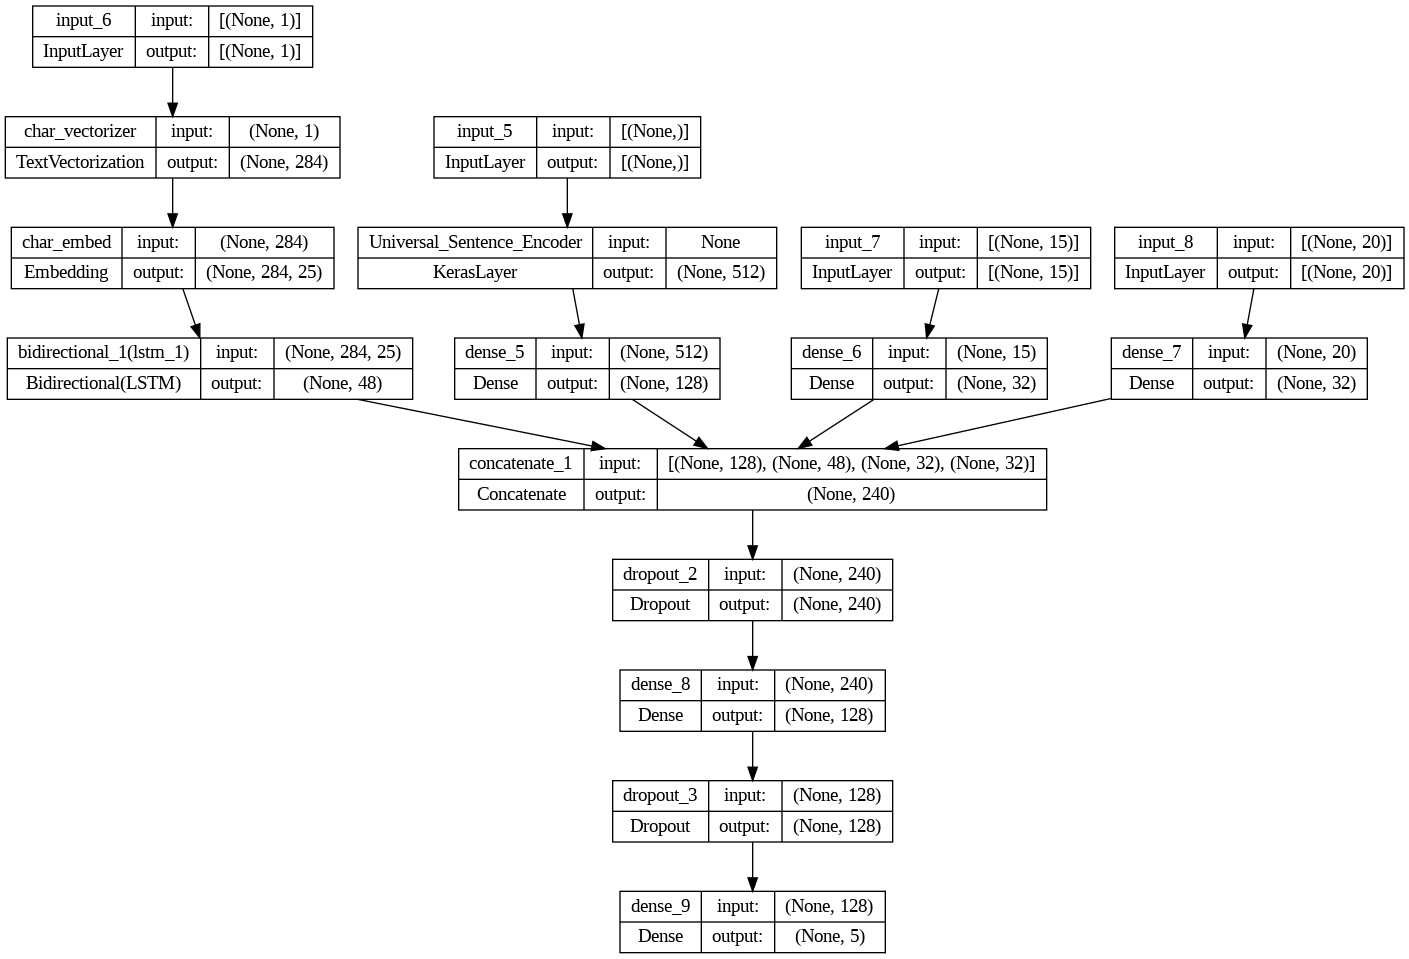

In [48]:
# Plot hybrid token and character model
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

In [50]:
# Compile token, char, and positional embedding model
model.compile(loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), #label_smoothing helps to prevent overfitting
               optimizer = tf.keras.optimizers.Adam(),
               metrics=["accuracy"])

### Building Data Pipelines

In [64]:
# Creating a data pipeline
train_data = tf.data.Dataset.from_tensor_slices((train_sentences,train_chars,train_line_numbers_OneHot,train_total_lines_OneHot)) # combines sentences and chars into a dataset
# train_labels = tf.data.Dataset.from_tensor_slices(train_labels_OneHot) # make labels

train_dataset = tf.data.Dataset.zip((train_data,tf.data.Dataset.from_tensor_slices(train_labels_OneHot))) # combines data & labels dataset into one big dataset

# Prefetch and batch train data
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [66]:
# Same process for val data
val_data = tf.data.Dataset.from_tensor_slices((val_sentences,val_chars,
                                                              val_line_numbers_OneHot,
                                                              val_total_lines_OneHot))
val_labels = tf.data.Dataset.from_tensor_slices(val_labels_OneHot)
val_dataset = tf.data.Dataset.zip((val_data,val_labels))

# Prefetch and batch val data
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [67]:
# Same process for test data
test_data = tf.data.Dataset.from_tensor_slices((test_sentences,test_chars,
                                                              test_line_numbers_OneHot,
                                                              test_total_lines_OneHot))
test_labels = tf.data.Dataset.from_tensor_slices(test_labels_OneHot)
test_dataset = tf.data.Dataset.zip((test_data,test_labels))

# Prefetch and batch test data
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

## Fitting the Model

In [69]:
model_history = model.fit(train_dataset, epochs = 3,
                          steps_per_epoch = int(0.1*len(train_dataset)),
                          validation_data = val_dataset,
                          validation_steps = int(0.1*len(val_dataset)))

Epoch 1/3
6912/6912 [==============================] - 134s 19ms/step - loss: 0.9241 - accuracy: 0.8392 - val_loss: 0.8681 - val_accuracy: 0.8639
Epoch 2/3
6912/6912 [==============================] - 135s 20ms/step - loss: 0.9213 - accuracy: 0.8419 - val_loss: 0.8655 - val_accuracy: 0.8705
Epoch 3/3
6912/6912 [==============================] - 135s 19ms/step - loss: 0.9203 - accuracy: 0.8432 - val_loss: 0.8636 - val_accuracy: 0.8694


## Model Prediction and Evaluation on test data

In [81]:
model.evaluate(test_dataset)

922/922 [==============================] - 10s 11ms/step - loss: 0.8698 - accuracy: 0.8669


[0.8697943687438965, 0.8669175505638123]

In [77]:
model_pred_probs = model.predict(test_dataset)
model_pred_probs

922/922 [==============================] - 9s 10ms/step


array([[0.6036385 , 0.04811869, 0.05595718, 0.24725108, 0.04503445],
       [0.5837333 , 0.04861643, 0.07449295, 0.23438647, 0.0587708 ],
       [0.30783474, 0.05807498, 0.2977644 , 0.17943576, 0.15689018],
       ...,
       [0.04263233, 0.06583551, 0.03267378, 0.03573693, 0.8231215 ],
       [0.0487307 , 0.7279891 , 0.05765954, 0.04255095, 0.1230697 ],
       [0.04076569, 0.7623943 , 0.0248445 , 0.04048028, 0.13151518]],
      dtype=float32)

In [78]:
model_pred = tf.argmax(model_pred_probs, axis=1)
model_pred[:10]

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 0, 2, 4, 2, 2, 4, 4, 4])>

In [79]:
# Getting helper functions
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-09-05 23:22:26--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-09-05 23:22:27 (102 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [82]:
from helper_functions import calculate_results
calculate_results(test_labels_LE, model_pred)

{'accuracy': 86.69175736615468,
 'precision': 0.8693699414914443,
 'recall': 0.8669175736615468,
 'f1': 0.8650320280677023}

## Visualizing the results

In [92]:
len(model_pred)

29493

In [94]:
# Changing the models predicted numbers to predicted names
i = 0
while i <= len(model_pred):
  model_pred_names = class_names[model_pred]
  i+=1

model_pred_names

array(['BACKGROUND', 'BACKGROUND', 'BACKGROUND', ..., 'RESULTS',
       'CONCLUSIONS', 'CONCLUSIONS'], dtype=object)

In [99]:
visual = pd.DataFrame({'Text': test_df['text'],
                       'Correct_Target': test_df['target'],
                       'Predicted_Target': model_pred_names})
visual

,Text,Correct_Target,Predicted_Target
0,many pathogenic processes and diseases are the...,BACKGROUND,BACKGROUND
1,it was recently demonstrated that supraphysiol...,BACKGROUND,BACKGROUND
2,"in the present study , we examined the associa...",BACKGROUND,BACKGROUND
3,"in addition , we compared plasma levels of map...",BACKGROUND,METHODS
4,a total of @ mi patients and @ control persons...,METHODS,RESULTS
...,...,...,...
29488,bone loss at the median forearm site was signi...,RESULTS,RESULTS
29489,breast tenderness occurred in @ percent of the...,RESULTS,RESULTS
29490,vaginal bleeding occurred at some time in @ pe...,RESULTS,RESULTS
29491,in postmenopausal women with low bone density ...,CONCLUSIONS,CONCLUSIONS


In [140]:
# Visualizing Random Sentences and their predicted label
import random
num = random.randrange(0,len(test_df))
i = 0
while i < 10:
  num = random.randrange(0,len(test_df))
  print(f"True Label: {test_df['target'][num]}, Predicted Label: {model_pred_names[num]}\nSentence: {test_df['text'][num]}\n\n")
  i+=1

True Label: METHODS, Predicted Label: RESULTS
Sentence: also , vo@peak , rest heart rate ( rhr ) , systolic blood pressure ( sbp ) , body weight ( bw ) , body mass index ( bmi ) and waist to hip ratio ( whr ) were measured in two groups .


True Label: METHODS, Predicted Label: METHODS
Sentence: patients then entered three consecutive , flexible-dose , @-week maintenance periods .


True Label: RESULTS, Predicted Label: RESULTS
Sentence: the mean amplitudes in nerve fibre related areas were smaller in glaucoma patients than in normal subjects .


True Label: RESULTS, Predicted Label: RESULTS
Sentence: no difference was found across the @ conditions in at-risk drinking at @ months , as the primary outcome variable , or in decrease in the number of drinks per drinking day , with all @ groups showing a significant reduction in both .


True Label: OBJECTIVE, Predicted Label: BACKGROUND
Sentence: minimally invasive surgery aims to achieve at least a similar clinical effectiveness with a qu

### Visualizing our most wrong predictions

In [108]:
pred_df = pd.DataFrame({"Sentence":test_df['text'],
                        "True Labels":test_df['target'],
                        "Predicted Labels":model_pred_names,
                        "pred_confidence": model_pred_probs.max(axis=1)})
pred_df

,Sentence,True Labels,Predicted Labels,pred_confidence
0,many pathogenic processes and diseases are the...,BACKGROUND,BACKGROUND,0.603639
1,it was recently demonstrated that supraphysiol...,BACKGROUND,BACKGROUND,0.583733
2,"in the present study , we examined the associa...",BACKGROUND,BACKGROUND,0.307835
3,"in addition , we compared plasma levels of map...",BACKGROUND,METHODS,0.567064
4,a total of @ mi patients and @ control persons...,METHODS,RESULTS,0.620908
...,...,...,...,...
29488,bone loss at the median forearm site was signi...,RESULTS,RESULTS,0.830057
29489,breast tenderness occurred in @ percent of the...,RESULTS,RESULTS,0.812566
29490,vaginal bleeding occurred at some time in @ pe...,RESULTS,RESULTS,0.823121
29491,in postmenopausal women with low bone density ...,CONCLUSIONS,CONCLUSIONS,0.727989


In [109]:
# 3. Find out in our DataFrame which predictions are wrong
pred_df["pred_correct"] = pred_df["True Labels"] == pred_df["Predicted Labels"]
pred_df.head()

,Sentence,True Labels,Predicted Labels,pred_confidence,pred_correct
0,many pathogenic processes and diseases are the...,BACKGROUND,BACKGROUND,0.603639,True
1,it was recently demonstrated that supraphysiol...,BACKGROUND,BACKGROUND,0.583733,True
2,"in the present study , we examined the associa...",BACKGROUND,BACKGROUND,0.307835,True
3,"in addition , we compared plasma levels of map...",BACKGROUND,METHODS,0.567064,False
4,a total of @ mi patients and @ control persons...,METHODS,RESULTS,0.620908,False


In [110]:
# 4. Sort our DataFrame to have most wrong predictions at the top
top_100_wrong = pred_df[pred_df["pred_correct"]==False].sort_values("pred_confidence", ascending=False)[:100]
top_100_wrong.head(20)

,Sentence,True Labels,Predicted Labels,pred_confidence,pred_correct
13004,this study provides class iii evidence that in...,METHODS,CONCLUSIONS,0.917997,False
16781,this study provides class ii evidence that for...,METHODS,CONCLUSIONS,0.865434,False
17641,community based intervention provided by a tea...,RESULTS,METHODS,0.860759,False
25542,this study provides class i evidence that trea...,METHODS,CONCLUSIONS,0.856528,False
10022,future research is needed to determine how bes...,RESULTS,CONCLUSIONS,0.853360,False
1348,to compare the efficiency of isotonic and hype...,BACKGROUND,OBJECTIVE,0.850864,False
544,the increase in cesarean sections because of d...,CONCLUSIONS,RESULTS,0.850313,False
6185,there were no significant differences between ...,METHODS,RESULTS,0.848528,False
1842,the mean + / - sd hypnotizability score ( harv...,METHODS,RESULTS,0.845723,False
18175,there was no significant difference between re...,METHODS,RESULTS,0.845136,False


In [111]:
from sklearn.metrics import confusion_matrix
confusion_matrix(test_df['target'], model_pred_names)

array([[2201,   18,  192,  238,   14],
       [  32, 3787,   29,    0,  578],
       [  72,   56, 9115,   10,  498],
       [ 861,    0,  175, 1340,    1],
       [  14,  332,  804,    1, 9125]])

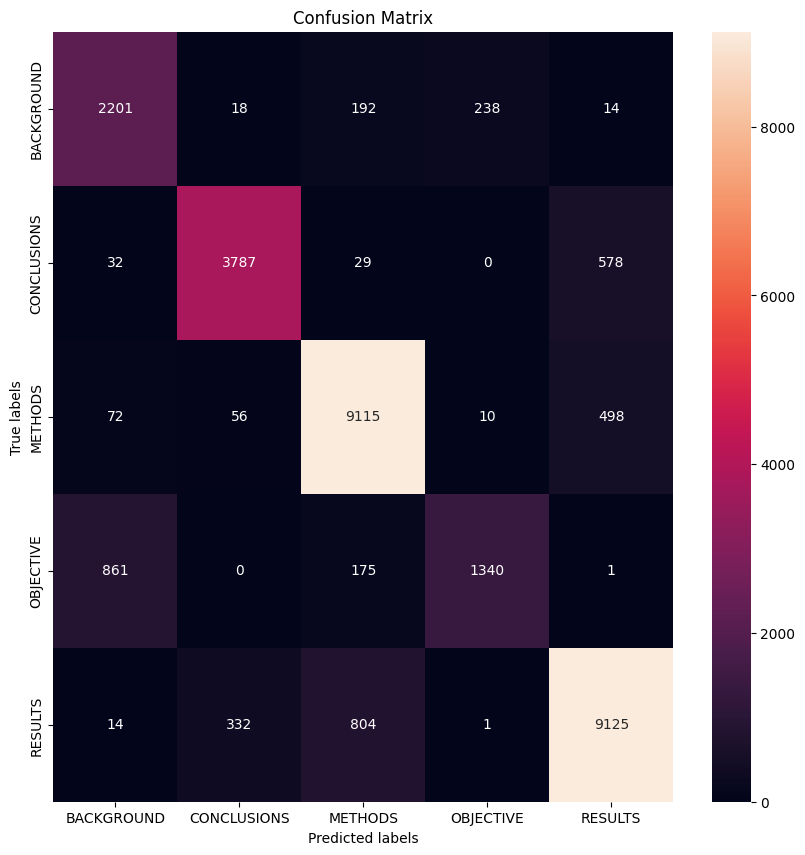

In [139]:
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,10))
cm = confusion_matrix(test_df['target'], model_pred_names)
ax= fig.add_subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(class_names); ax.yaxis.set_ticklabels(class_names);
plt.show()